# Treebeard Example Notebook - Hello World

Treebeard lets you set up Continuous Integration and testing for your data science projects very easily.  
It also works natively with Jupyter notebooks.  
This notebook and repository shows an example project setup.



## Project dependencies
Treebeard uses [`repo2docker`](https://github.com/jupyter/repo2docker/) to build a container for your project.  
All that is required to build the container is a dependencies file.  
This should be either `requirements.txt`, a pipenv `Pipfile`, or a Conda `environment.yml` file.

## Setting up your project

From makefiles to bash scripts, setting up everything that is needed to get a project running on a colleague's laptop for a fresh install can be painful.  
We recommend using notebooks for the initial project setup scripts, with the advantage that as much as possible can be written in Python.  
Where shell scripts are needed, `treebeard` has a helper function `treebeard.helper.shell`. Using this avoids some of the pitfalls of bash scripts. (X, Y)  
Setup artifacts and logs are visible in the setup notebook for debugging.  

The project dependencies can also be installed, preferably in a project environment, from these notebooks (`jupyter`, `treebeard` and any other dependencies necessary for setup must be available).

The cloud container that Treebeard builds to test your project will automatically run these setup notebooks.  
They should be located in `treebeard/container_setup.ipynb` as in this example.

## Configuration

The minimum configuration needed to run on Treebeard is one Github Action file, and for your `TREEBEARD_API_KEY` to be set in Github Secrets for your project.  
You can find your Treebeard API key in the top-right settings menu in [treebeard.io/admin](https://treebeard.io/admin).  
Set secrets at `https://github.com/<YOUR_USERNAME>/<YOUR_PROJECT>/settings/secrets`


### Github Action
Treebeard uses Github Actions to perform tasks when new code is added to the project, or on a schedule.

Github Action workflow files are found under `.github/workflows`. You can see two examples in this project.

See the docs for a full explanation of Treebeard's Github Action

### treebeard.yaml

The `treebeard.yaml` file contains project configuration options, such as any files to ignore, any notebooks to run or not to run (all are run by default), output directory tags, and further variables for integrations and optimisations.

See the [docs](https://treebeard.readthedocs.io/en/latest/project_config.html) for an explanation of project configuration

## Outputs
Any artifacts like charts or datafiles from your notebooks can be saved in a named output directory.  
If so, they will be saved on a cloud storage bucket, versioned, and made available via URL endpoints.  
Outputs will be listed on the Treebeard admin page following each run of the project.  

In [ ]:
# create an outputs directory if it does not exist
import os
if 'output' not in os.listdir(): os.mkdir('output')

# A small example
Check a data source daily, and on commit.  

The [Mauna Loa Observatory](https://www.esrl.noaa.gov/gmd/obop/mlo/) is a USA NOAA Earth System Research Laboratory. It publishes **measurements of atmospheric CO2 concentration** regularly. The Observatory publishes its own charts [here](https://www.esrl.noaa.gov/gmd/ccgg/trends/mlo.html), but we can recreate them.



In [6]:
# Setup
import matplotlib.pyplot as plt 
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

In [36]:
# Weekly CO2 data is published here, there are also other datafeeds available
url = "ftp://aftp.cmdl.noaa.gov/products/trends/co2/co2_weekly_mlo.txt"

# Pandas can read remote URL file contents
# Skip the first 49 rows as they are explanatory text
# Reading them is helpful though as they define the column names and missing number fills
df = pd.read_table(url, skiprows=49, header=None)

# Use a regex to turn the variable whitespace between columns into commas
df[0] = df[0].str.strip().str.replace("(\s{1,})", ",")

# Split the column by commas and expand into columns
df = df[0].str.split(',', expand=True)

# Set the column headers
columns = ["yr", "mon", "day", "decimal", "ppm", "days", "1_yr_ago", "10_yr_ago", "since_1800"]
df.columns=columns

# Replace -999.99 with NAs
df = df.replace('-999.99', np.nan)

# Create datetime column
df['date'] = pd.to_datetime(dict(year=df['yr'], month=df['mon'], day=df['day']))

# Set types
df['ppm'] = df['ppm'].apply(pd.to_numeric)

df.tail()

,yr,mon,day,decimal,ppm,days,1_yr_ago,10_yr_ago,since_1800,date
2400,2020,5,17,2020.3757,416.97,5,414.72,393.46,133.42,2020-05-17
2401,2020,5,24,2020.3948,417.43,7,414.40,392.63,134.05,2020-05-24
2402,2020,5,31,2020.4139,417.20,6,414.28,393.28,134.09,2020-05-31
2403,2020,6,7,2020.4331,416.34,5,414.39,392.70,133.59,2020-06-07
2404,2020,6,14,2020.4522,416.42,5,413.77,391.79,134.07,2020-06-14


## Plot
Note that the plot is saved in the `output` directory.  
This means it will be available on Treebeard to preview, download and serve via our API.


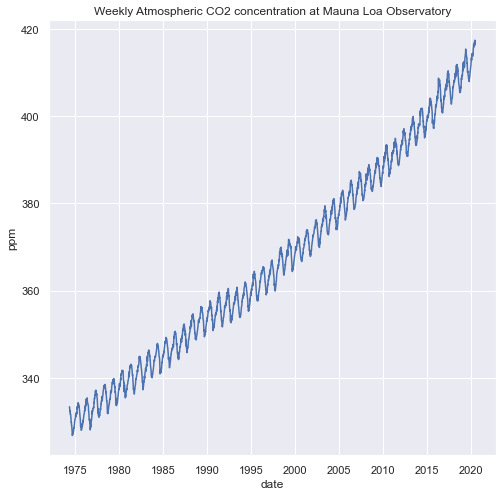

In [37]:
# plot
sns.set()
fig, ax = plt.subplots(figsize=(8,8))
sns.lineplot(x='date', y='ppm', data=df)
plt.title("Weekly Atmospheric CO2 concentration at Mauna Loa Observatory")
plt.savefig('output/co2_concentration.png', dpi=150, bbox_inches='tight')